<h1>문자를 읽을 수 있는 딥러닝</h1>

문자를 읽는 기술인 OCR(Optical Character Recognition, 광학 문자 인식)은 산업적으로 매우 유용한 기술이이다다. 딥러닝이 도입된 이후 OCR 기술이 획기적으로 개선되어 많은 산업 도메인에 유용하게 사용될 수 있는 가능성이 열리고 있다. 

### 실습목표
---

- OCR의 과정을 이해합니다.
- 문자인식 결과의 표현방식을 이해합니다.
- 파이썬을 통해 OCR을 사용할 수 있습니다.

### 학습 목차
---

- 들어가며
- 기계가 읽을 수 있나요?
- 어떤 과정으로 읽을까요?
- 딥러닝 문자인식의 시작
- 사진 속 문자 찾아내기 - detection
- 사진 속 문자 읽어내기 - recognition
- keras-ocr 써보기
- 테서랙트 써보기
- 프로젝트 : 다양한 OCR 모델 비교하기

### 준비물
---

$ mkdir -p ~/aiffel/EXPLORATION/18/ocr_python



## 기계가 읽을 수 있나요?

사람이 문자를 읽으려면 어떤 과정을 거칠까? 문자가 있다는 것을 1)인식하고, 인식한 문자를 2)해독하는 과정을 거치는 것이 일반적이다. 

기계가 문자를 읽는 과정도 이와 다르지 않다. 컴퓨터 비전에서 사용하는 용어로 위의 두 단계를 번역하자면 문자의 존재를 1)Detection 하고, 어떤 문자인지 판독하는 2)Recognition 으로 나눌 수 있다.

구글 OCR API를 이용하여 어플리케이션을 만들 수 있다.

### STEP 1) 구글의 파이썬 API 인터페이스 모듈을 아래와 설치합니다.

$ pip install --upgrade google-api-python-client

$ pip install google-cloud-vision

### STEP 2) Google Cloud Vision API 사용

서비스 계정 및 인증키를 생성. 브라우저에서 다운로드한 인증키는 my_google_api_key.json이라는 파일명으로 변경. (파일은 프로젝트 이름으로 시작하는 파일명으로 자동 저장됩니다.)

cloud jupyter를 열고 my_google_api_key.json 파일을 ~/aiffel/EXPLORATION/18/ocr_python 디렉토리에 업로드

### STEP 3) API 사용 테스트

API를 활용하는 코드는 아래와 같다. 사용할 이미지를 cloud jupyter 를 이용하여 업로드 후 경로를 지정

In [27]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [28]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/EXPLORATION/18/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = path = os.getenv('HOME')+'/aiffel/EXPLORATION/18/ocr_python/interstellar-imax-poster.jpeg'   

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

-rw-r--r-- 1 root root 2337 Sep 21 02:27 /aiffel/aiffel/EXPLORATION/18/ocr_python/my_google_api_key.json


PermissionDenied: 403 This API method requires billing to be enabled. Please enable billing on project #468260795686 by visiting https://console.developers.google.com/billing/enable?project=468260795686 then retry. If you enabled billing for this project recently, wait a few minutes for the action to propagate to our systems and retry.

## 어떤 과정으로 읽을까요?



구글 API에서는 문자의 영역을 사각형으로 표현하고 우측에 Block과 Paragraph로 구분해서 인식 결과를 나타내고 있었다. 구글 API가 이미지에 박스를 친 다음 박스별 텍스트의 내용을 알려준 것처럼, 문자 모델은 보통 두 단계로 이뤄진다.

먼저 입력받은 사진 속에서 문자의 위치를 찾아낸다. 이 과정을 Text Detection(문자검출) 이라고 한다. 찾은 문자 영역으로부터 문자를 읽어내는 것은 Text Recognition(문자인식) 이다. 예를 들어 아래 카카오의 OCR 모델은 먼저 문자가 있는 영역의 정보 (coord, Text Recognition)를 찾아내고, 각 영역에서 문자를 인식하고 있다. 이렇게 문자 인식 모델은 Text Detection과 Recognition 두 과정을 통해서 사진 속의 문자를 읽을 수 있게 된다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/18/etc/E-19-4.max-800x600_lhFXcl2.png?raw=true)

위 그림에서는 문자의 영역을 표현하는 방법으로 사각형의 네 꼭짓점 좌표를 알려 주는 방법을 제시하고 있습니다. 하지만 다른 도형이나 표현 방법을 사용할 수도 있다. 

## 딥러닝 문자인식의 시작

![](https://github.com/MulderKim/EXPLORATION/blob/main/18/etc/E-19-5.max-800x600_fSsqPX1.png?raw=true)

다들 딥러닝을 배우는 동안 MNIST 데이터셋을 여러 번 접했을것이다. 주로 0부터 9까지의 손으로 쓰인 숫자가 있는 이미지를 이미지 분류 문제로 딥러닝을 이용하여 풀어보는 데이터셋으로 사용한다!

MNIST가 딥러닝 데이터셋의 "hello, world!"라면, LeNet은 CNN의 "hello, world!"라 할 수 있다. 1998년에 발표된 LeNet은 우편번호나 손글씨를 읽기 위해서 만들어졌다. 앞서 학습한 MNIST로 LeNet을 훈련시킨다면 우편번호를 읽을 수 있는 것이다. 위 그림은 LeNet-5의 구조다. 요즘 나온 모델들을 생각한다면 구조가 상당히 간단하다. Convolution 레이어와 최종 출력 레이어로 이뤄져 있다.

아래 이미지는 입력과 각 Layer의 활성화를 시각화한 LeNet의 MNIST 데모 이미지다. 우측 상단에서 인식 결과를 확인할 수 있다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/18/etc/E-19-6.gif?raw=true)
![](https://github.com/MulderKim/EXPLORATION/blob/main/18/etc/E-19-7.png?raw=true)

하지만 이렇게 단순한 분류 모델만으로는 우리가 위에서 구글 API로 테스트해 보았던 복잡한 결과를 얻을 수 없다. 넓고 복잡한 이미지에서 글자 영역을 찾을 수 없을뿐더러 글자를 영역별로 잘라서 넣더라도 우리가 인식하기를 원하는 사진은 여러 글자가 모여있기 때문에 단순한 분류 문제로 표현이 불가능하다.

## 사진 속 문자 찾아내기 - detection

![](https://github.com/MulderKim/EXPLORATION/blob/main/18/etc/E-19-10.max-800x600_iGdm4cV.png?raw=true)

사진 속 문자를 찾아내는 최근의 딥러닝 모델은 일반적인 Object Detection(객체 인식) 방법으로 접근합니다. 이미지 속에서 물체를 찾아내는 딥러닝 모델에게 문자를 찾도록 학습을 시킨 것이죠. 물론 문자의 특성에 따라서 모델을 변경해 주기도 합니다.

딥러닝 기반 객체 검출 방법에는 Regression(회귀) 방식이나 Segmentation(세그멘테이션) 방식이 있습니다. Regression은 기준으로 하는 박스 대비 문자의 박스가 얼마나 차이가 나는지를 학습합니다. Segmentation은 픽셀 단위로 해당 픽셀이 문자를 표현하는지를 분류하는 문제(pixel-wise classification)라고 볼 수 있습니다. 객체 검출과 세그멘테이션에 대한 자세한 방법은 다른 강의에서 배우도록 합시다. 여기서는 문자를 찾아내는 딥러닝 모델이 우리가 흔히 들어본 Object Detection과 큰 차이가 없다는 것만 알아두셔도 됩니다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/18/etc/E-19-9.max-800x600_lt28Nt5.png?raw=true)
![](https://github.com/MulderKim/EXPLORATION/blob/main/18/etc/E-19-8.max-800x600_wGIgZfi.png?raw=true)


## 사진 속 문자 읽어내기 - recognition

![](https://github.com/MulderKim/EXPLORATION/blob/main/18/etc/E-19-11.png?raw=true)

문자 인식은 사진 속에서 문자를 검출해내는 검출 모델이 영역을 잘라서 주면 그 영역에 어떤 글자가 포함되어 있는지 읽어내는 과정이다. 아래는 ICDAR15라는 OCR 데이터셋에서 단어 단위로 잘린 이미지다. 문자 인식 모델은 이렇게 작게 잘린 이미지가 들어오면 이미지 속에 어떤 단어가 포함됐는지 찾아낸다.

이 과정은 이미지 문제보다는 자연어 처리에서 많은 영감을 받았다. 자연어 처리를 한다면 RNN이 떠오르겠지만... 이미지 내의 문자 인식 모델의 기본적인 방법 중 하나가 바로 CNN과 RNN을 결합한 CRNN 모델이다. 이미지 내의 텍스트와 연관된 특징을 CNN을 통해 추출한 후에 스텝 단위의 문자 정보를 RNN으로 인식하는 것이다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/18/etc/E-19-12.max-800x600_y9DP2Mu.png?raw=true)

이렇게 검출 결과로부터 인식 모델을 통해 문자를 인식하고 나면 구글 API의 결과처럼 사진 속 영역에 표시를 하고 그 영역에 어떤 문자가 적혀있는지 알 수 있는 OCR 시스템이 된다.

OCR은 이미 실용적인 단계로의 연구가 많이 진척되어, 실전 레벨의 구체적인 정보를 접하는 것이 훨씬 도움이 될 것이다.

## keras-ocr 써보기

![](https://github.com/MulderKim/EXPLORATION/blob/main/18/etc/E-19-14.max-800x600.png?raw=true)

keras-ocr은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 해준다. 공식 문서에도 나와 있듯, 검출 모델로는 네이버 데뷰 2018 영상에서 소개한 CRAFT(Character Region Awareness for Text Detection)를 사용하고, 인식 모델로는 앞에서 설명한 CRNN을 사용한다.

keras-ocr 버전을 클라우드 쉘에서 확인해 보자.

$ pip list | grep keras-ocr

필요한 라이브러리인 keras_ocr 과 인식 결과의 시각화를 위한 matplotlib.pyplot 를 불러온다. keras_ocr.pipeline.Pipeline() 는 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러오게 된다. 검출기와 인식기를 위한 가중치 하나씩을 불러올것이다.


In [29]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


만들어둔 파이프라인의 recognize() 에 이미지를 몇 개 넣어보자.

이미지 소스의 url을 사용할 것이며, 이미지는 https://unsplash.com/s/photos/text 에서 가져왔다.

In [30]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

이제 인식된 결과를 pyplot으로 시각화를 해보면...

사용이 매우 간단하다! 내부적으로 recognize() 는 검출기와 인식기를 두고, 검출기로 바운딩 박스(bounding box, 문자가 있는 영역을 표시한 정보)를 검출한 뒤, 인식기가 각 박스로부터 문자를 인식하는 과정을 거치도록 하자.

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


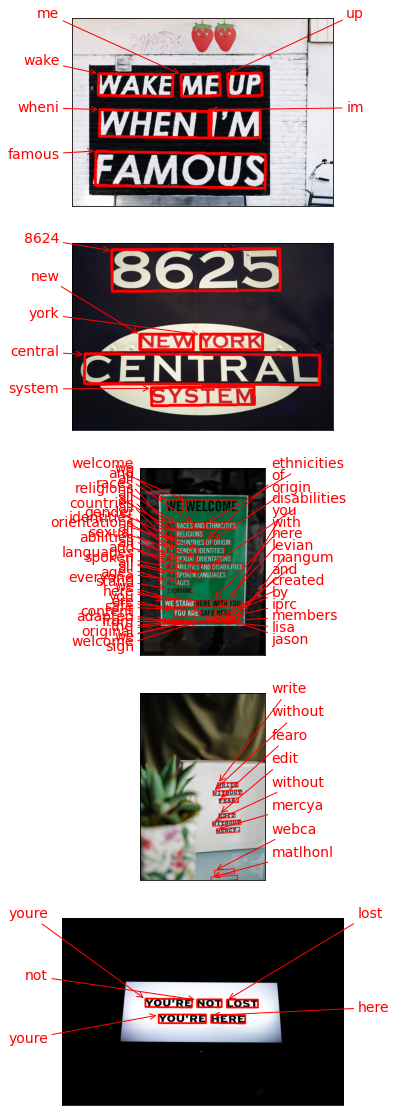

In [31]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

(주의사항)
keras-ocr은 한글 데이터셋으로 훈련이 되어있지 않은 모델이다. 한글 텍스트의 detection은 정상적으로 진행되더라도 recognition 결과가 엉뚱하게 나올 수 있음에 주의할것.

## 테서랙트 써보기

테서랙트(Tesseract) 라이브러리로 이미지에서 문자를 인식해 보자. 테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재는 버전 4와 Tesseract.js등으로 확장되는 등 많은 곳에서 사용되고 있다. 버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116 개 국어를 지원하고 있다.

오픈소스라는 점은 여러분들이 원하는 프로젝트에 활용하기 쉽다는 것을 뜻하니, 직접 해 보면서 익혀두면 나중에 간단한 OCR 모델이 필요할 때 빠르게 활용할 수 있다.

### 1) 테서랙트 설치하기

클라우드 쉘에서 아래 코드를 사용해 테서랙트 관련 패키지들을 설치.

$ sudo apt install tesseract-ocr

$ sudo apt install libtesseract-dev

### 2) 테서랙트 파이썬 wrapper 설치하기

Pytesseract는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리(wrapper library)다. 파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해준다.

$ pip list | grep pytesseract

만약 설치가 안 되어 있다면 아래 명령어를 이용해 설치.

$ pip install pytesseract

### 3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)

테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있는데 OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저 해 보자..

In [32]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/EXPLORATION/18/ocr_python'
img_file_path = work_dir + '/interstellar-imax-poster.jpeg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/EXPLORATION/18/ocr_python/0000.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0001.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0002.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0003.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0004.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0005.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0006.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0007.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0008.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0009.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0010.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0011.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0012.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0013.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0014.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0015.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0016.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0017.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0018.png
/aiffel/aiffel/EXPLORATION/18/ocr_python/0019.png


위에서 구현한 crop_word_regions() 함수는 여러분이 선택한 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수다.

기본적으로 pytesseract.image_to_data() 를 사용한다. 파이썬에서 편하게 사용하기 위해서 pytesseract 의 Output 을 사용해서 결괏값의 형식을 딕셔너리(DICT) 형식으로 설정해 준다. 이렇게 인식된 결과는 바운딩 박스의 left, top, width, height 정보를 가지게 된다. 바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 PIL(pillow) 또는 opencv 라이브러리를 사용해 잘라(crop)서 cropped_image_path_list에 담아 리턴했다.

(주의) 위 코드에서 lang='kor' 로 바꾸면 에러가 발생합니다. 테서랙트의 언어팩을 설치해야 정상 동작하게 된다.

$ sudo apt install tesseract-ocr-kor


### 4) 테서랙트로 잘린 이미지에서 단어 인식하기

검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결괏값으로 나오는 image_to_string()를 사용하게 된다.

이렇게 인식된 결과가 실제 이미지와 맞는지 확인해 보자.

In [33]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

-

J

MIC

HA

Evens

fr

iB

cael

Nery

TL a

Wha

CHASTAIN

AND

ees

3

pee ER | NC E

nee

aot

IMIA:

x


“PAR AME

a

PO tee 8) eee

INWITH I

ss

rages

anies

Boat

SYVNCOPY/EYND

piTent

nel B16

()PHER

ie

SRNR

Nv E

i ne ea

DIED

eee,

wiv

BL

on


ms

Weleeaii


Sileeee

Soa

hia aey cr

A

ee HCH

Tl Oh eae

\

aT HT Pee

KORDAN

COLDBERCG

away

yen

pe

nec

DaTenTn

eel

pes SH

HMONATHAN

ee

\\1)

( HAISTOPHER

NOLAN |

OU

DAY eal

se etehiea te

Cie E eR HONE SMR

NOLAN

PAA era

(OBST

srr ~nigeigh- ++ Aah

es ee

Sarvaln irae

an

Die

ry

NreNiaVi:):

ree

SELEC |

SEQUENCES

miele.

Vite

Ws? 4

CAMERAS

mterstellarmovie.com

“interstellar


ee eee ya Se Pa go ERT a ST ren aaa aac


hd

—_ ee ee ee

—s Pe Tl he

ad eedll geaeahose

|

=o

a

Done


## 프로젝트 : 다양한 OCR모델 비교하기

Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았다.

무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을 것이다. 그런데 과연 어떤 것을 사용하는 것이 좋을까?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일이다. 

라이브러리 불러오기

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

from glob import glob

### Step1. 검증용 데이터셋 준비
---

OCR 관련해서 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이다. 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 한다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요하다.

너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 말자.

In [35]:
data_dir = os.getenv('HOME')+'/aiffel/EXPLORATION/18/ocr_python/img/'
img_list = glob(data_dir + '*.jpg')
img_list.sort()
img_list

['/aiffel/aiffel/EXPLORATION/18/ocr_python/img/01.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/02.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/03.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/04.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/05.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/06.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/07.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/08.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/09.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/10.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/11.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/12.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/13.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/14.jpg',
 '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/15.jpg']

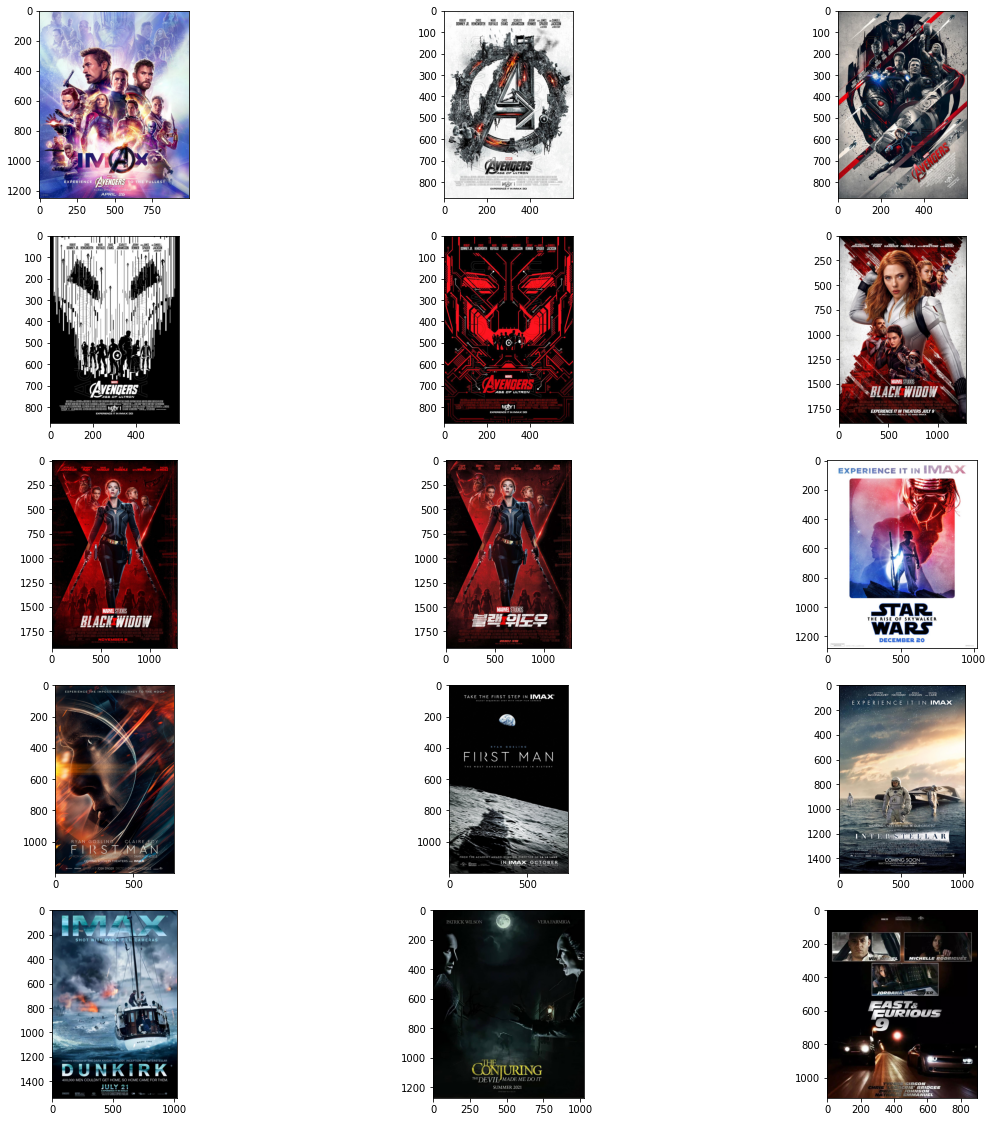

In [36]:
# 이미지 출력
plt.figure(figsize=(20, 20))
for i, im in enumerate(img_list):
    plt.subplot(5, 3, i+1)
    image = img.imread(im)
    plt.imshow(image)

### Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행
---

위 3가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보았다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 보자.

### google OCR API

In [37]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
        print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [38]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/EXPLORATION/18/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
for i, image in enumerate(img_list):
    print(image)
    
    # 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
    detect_text(image)
    print('-------------------------------------------------------------------')


-rw-r--r-- 1 root root 2337 Sep 21 02:27 /aiffel/aiffel/EXPLORATION/18/ocr_python/my_google_api_key.json
/aiffel/aiffel/EXPLORATION/18/ocr_python/img/01.jpg


PermissionDenied: 403 This API method requires billing to be enabled. Please enable billing on project #468260795686 by visiting https://console.developers.google.com/billing/enable?project=468260795686 then retry. If you enabled billing for this project recently, wait a few minutes for the action to propagate to our systems and retry.

### keras-ocr

In [39]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [40]:
images_keras_ocr = [keras_ocr.tools.read(image) for image in img_list]
prediction_groups = [pipeline.recognize([image]) for image in img_list]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


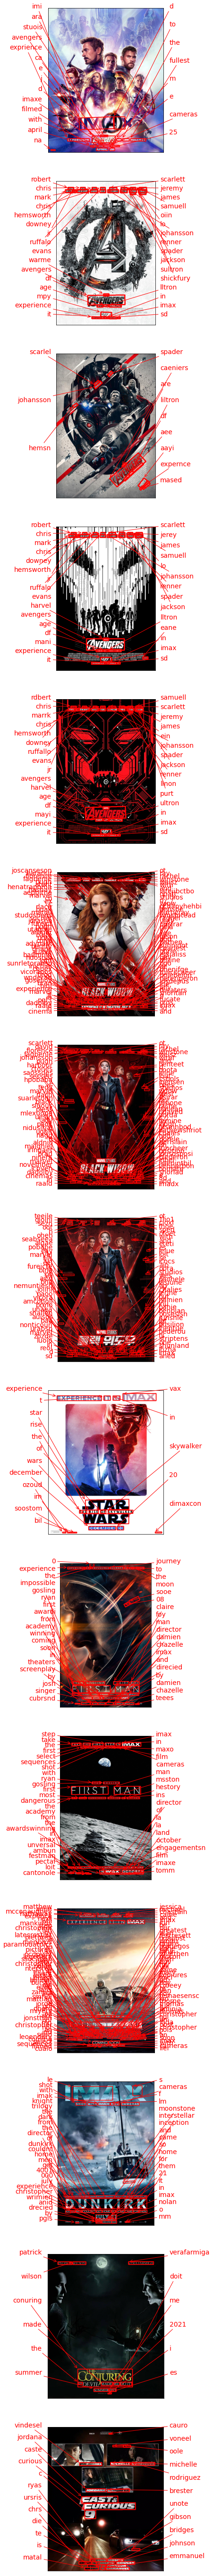

In [41]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images_keras_ocr), figsize=(100, 100))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images_keras_ocr[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

In [42]:
import os
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image
from pytesseract import Output

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    try:
        if not os.path.exists(output_path):
            os.mkdir(output_path)
        custom_oem_psm_config = r'--oem 3 --psm 3'
        image = Image.open(image_path)

        recognized_data = pytesseract.image_to_data(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )

        top_level = max(recognized_data['level'])
        index = 0
        cropped_image_path_list = []
        for i in range(len(recognized_data['level'])):
            level = recognized_data['level'][i]

            if level == top_level:
                left = recognized_data['left'][i]
                top = recognized_data['top'][i]
                width = recognized_data['width'][i]
                height = recognized_data['height'][i]
                output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
                cropped_image = image.crop((
                    left,
                    top,
                    left+width,
                    top+height
                ))
                cropped_image.save(output_img_path)
                cropped_image_path_list.append(output_img_path)
                index += 1
        return cropped_image_path_list
    except SystemError as e:
        print(e)

In [43]:
work_dir = os.getenv('HOME')+'/aiffel/EXPLORATION/18/ocr_python/img'

cropped_image_path_list = {}
for i, img in enumerate(img_list):
    dir_path = work_dir + f'/{i}'
    path_list = crop_word_regions(img, dir_path)
    cropped_image_path_list[i] = path_list

In [44]:
cropped_image_path_list

{0: ['/aiffel/aiffel/EXPLORATION/18/ocr_python/img/0/0000.png'],
 1: ['/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0000.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0001.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0002.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0003.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0004.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0005.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0006.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0007.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0008.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0009.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0010.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0011.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0012.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0013.png',
  '/aiffel/aiffel/EXPLORATION/18/ocr_python/img/1/0014.png',
  '/aiffel/aiffel

In [45]:
def recognize_images(i, cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    print(f'---------------------------{i}---------------------------')
    result = ''
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        result += " ".join(recognized_data['text'].split()) + " "
    print(result)
    print()

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
for key, value in cropped_image_path_list.items():
    if value:
        recognize_images(key, value)

---------------------------0---------------------------
: 

---------------------------1---------------------------
JEREMY oailh JAMES LA} NOMIFL L DOWNEY IR SE MSWIRTH aUFFAIL ANG ITHANSSON RENNER SF ADE JALRSUN g 7 iv ~AMEHIENL. -— it NV iViAA <i 

---------------------------2---------------------------
 

---------------------------3---------------------------
poe Ty pry EY]  oT fpume oo waow | evoe™ =erpsocte * com ... nH |  RUBE wm JAMMED iw] SAMUEL L WAY iit sEMSWIRTH aIEFAIT  InANSSTN   JAUNOUN | em” 4 5 = Oi eee ieee ieee  , eet ari tis    yoo de sie MK fed —_ CD ee ae wake Me Te ay DSK ay emcee esse ec l e. 

---------------------------4---------------------------
ts 

---------------------------5---------------------------
~~ x oe i‘ e es \ : me a”    j SN rye Ian ams; amo we ee Pe | PuUGbH AYN, FAGE >> ENLE Tah aT tT NT ANL   “a ‘“ an wane  EXPERIENGE IT |  it A 1 Ble)\2)", Cinema, 74 AN 2 cre, A NIT > ivsrs+?.4  

---------------------------6---------------------------
 ee 

### Step3. 테스트 결과 정리
---

모듈들마다 출력 형태가 다르다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것이다. 시각화 방법이 함께 활용된다면 더욱 좋겠다.

In [49]:
import time

plt.figure(figsize=(50, 50))
for i, im in enumerate(img_list):
    print(f'{i}번째 이미지 결과 -------')
#     plt.subplot(10, 1, i+1)
#     image = img.imread(im)
#     plt.imshow(image)
#     time.sleep(3)
    print('<Google OCR API>')
 #   print(detect_text_result(im))
    print('<keras-ocr>')
    keras_ocr_result = [txt[0] for txt in prediction_groups[i][0]]
    keras_ocr_result = ' '.join(keras_ocr_result)
    print(keras_ocr_result)
    
    

0번째 이미지 결과 -------
<Google OCR API>
<keras-ocr>
d imi ara stuois avengers exprience to the fullest ca e j d m e filmed with imaxe cameras april 25 na
1번째 이미지 결과 -------
<Google OCR API>
<keras-ocr>
robert chris mark chris scarlett jeremy james samuell oiin lo hemsworth downey jr ruffalo evans johansson renner spader jackson sultron shickfury warme avengers age df lltron mpy experience it in imax sd
2번째 이미지 결과 -------
<Google OCR API>
<keras-ocr>
spader scarlel johansson hemsn caeniers are liltron df aee aayi expernce mased
3번째 이미지 결과 -------
<Google OCR API>
<keras-ocr>
robert chris mark chris scarlett jerey james samuell lo downey hemsworth jr ruffalo evans johansson renner spader jackson harvel avengers age df lltron eane mani experience it in imax sd
4번째 이미지 결과 -------
<Google OCR API>
<keras-ocr>
samuell rdbert chris marrk chris scarlett jeremy james ein hemsworth johansson spader jackson downey jr ruffallo evans renner llnon purt harvel avengers age df ultron mayi experience it in

<Figure size 3600x3600 with 0 Axes>

### Step4. 결과 분석과 결론 제시
---

- 우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다.
- 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다.
- 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

### 회고

구글 API 결제 관련 예로로 시작되서 영 꼬여버린 그래서 손이 가다 만 노드이다. 예전에 사용했던 이력이 있어서인지 처음부터 에러가 계속 뜨고 그러다보니 진행하다 뚝뚝 끊기면서... 결국 구글 OCR 기능은 포기해버리면서 노드 진행하는데... 집중이 안되서 거의 포기하다시피하고 만...